In [5]:
import pandas as pd
import sys
import os

# Add the parent directory to sys.path so 'src' can be imported
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.load import load_finbert_csv
from src.clean import parse_dates, validate_probs, basic_info
from src.periods import tag_periods
from src.viz import (
    plot_sentiment_hist, plot_label_counts, plot_confidence_hist, plot_pairwise
)

In [7]:
df, path = load_finbert_csv(filename="headlines_finbert.csv", subdir="raw")
print("Loaded:", path)
df.head()

Loaded: /Users/erinjiyoonkim/Downloads/Headlines Project/Headlines-Project/data/raw/headlines_finbert.csv


,Title,Date,OP,CP,OP_next,finbert_label,finbert_neg,finbert_neu,finbert_pos,finbert_confidence
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",02/01/2008,1468.0,1447.16,1447.5,negative,0.604176,0.207425,0.188399,0.604176
1,Dow Tallies Biggest First-session-of-year Poin...,02/01/2008,1468.0,1447.16,1447.5,negative,0.962149,0.026425,0.011426,0.962149
2,2008 predictions for the S&P 500,02/01/2008,1468.0,1447.16,1447.5,neutral,0.122815,0.824247,0.052938,0.824247
3,"U.S. Stocks Higher After Economic Data, Monsan...",03/01/2008,1447.5,1447.16,1444.0,positive,0.064193,0.074181,0.861626,0.861626
4,U.S. Stocks Climb As Hopes Increase For More F...,07/01/2008,1414.1,1416.18,1415.7,positive,0.165056,0.248378,0.586566,0.586566


In [8]:
df = parse_dates(df, "Date")
df = validate_probs(df)
info = basic_info(df)
info


{'rows': 19127,
 'cols': ['Title',
  'Date',
  'OP',
  'CP',
  'OP_next',
  'finbert_label',
  'finbert_neg',
  'finbert_neu',
  'finbert_pos',
  'finbert_confidence'],
 'na_counts': {'Title': 0,
  'Date': 0,
  'OP': 0,
  'CP': 0,
  'OP_next': 0,
  'finbert_label': 0,
  'finbert_neg': 0,
  'finbert_neu': 0,
  'finbert_pos': 0,
  'finbert_confidence': 0}}

In [9]:
df = tag_periods(df, date_col="Date", yaml_path="../config/periods.yaml")
df[["Date","finbert_label","period_type","period_name"]].head()


,Date,finbert_label,period_type,period_name
0,2008-01-02,negative,normal,Normal
1,2008-01-02,negative,normal,Normal
2,2008-01-02,neutral,normal,Normal
3,2008-01-03,positive,normal,Normal
4,2008-01-07,positive,normal,Normal


In [10]:
df.to_csv("../data/interim/headlines_finbert_clean.csv", index=False)
print("Saved cleaned file to data/interim/headlines_finbert_clean.csv")


Saved cleaned file to data/interim/headlines_finbert_clean.csv


In [11]:
desc = df[["finbert_neg","finbert_neu","finbert_pos","finbert_confidence"]].describe()
display(desc)
desc.to_csv("../results/tables/sentiment_describe.csv")


,finbert_neg,finbert_neu,finbert_pos,finbert_confidence
count,19127.000000,19127.000000,19127.000000,19127.000000
mean,0.264726,0.532770,0.202504,0.819200
std,0.342013,0.370519,0.279003,0.139493
min,0.006408,0.008271,0.006386,0.340194
25%,0.027093,0.100056,0.030172,0.747700
50%,0.063328,0.677048,0.061570,0.878242
75%,0.444100,0.898447,0.219542,0.922489
max,0.976530,0.955761,0.957808,0.976530


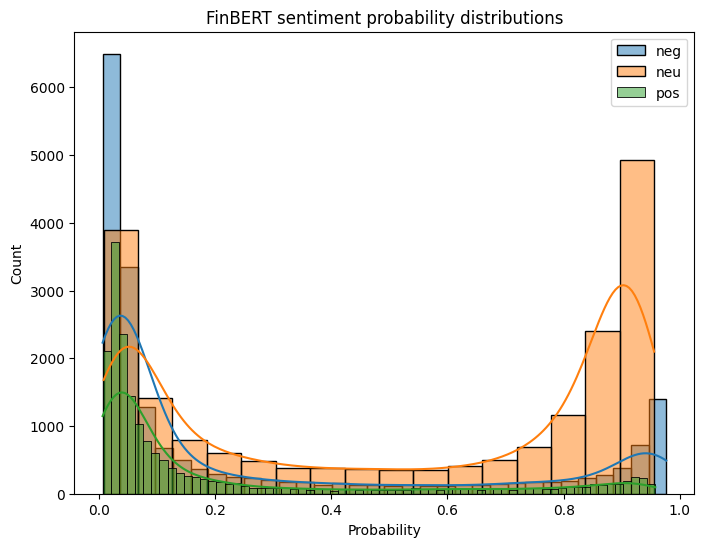

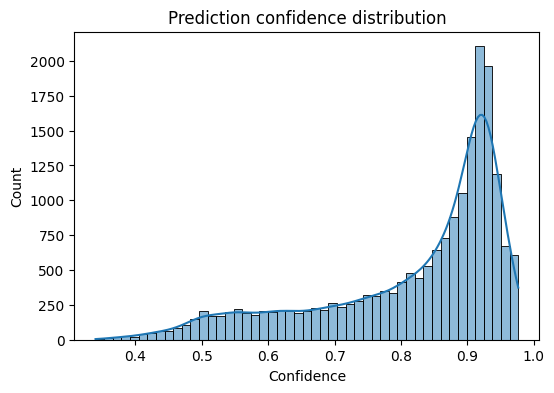

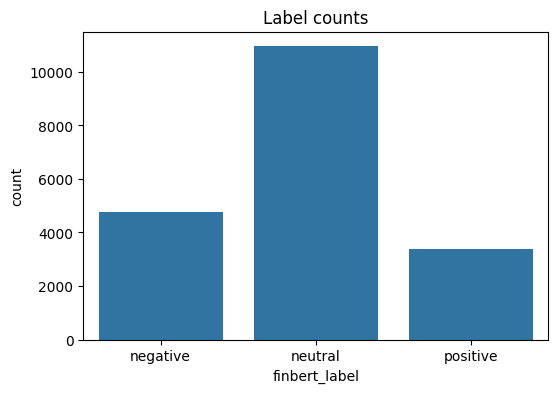

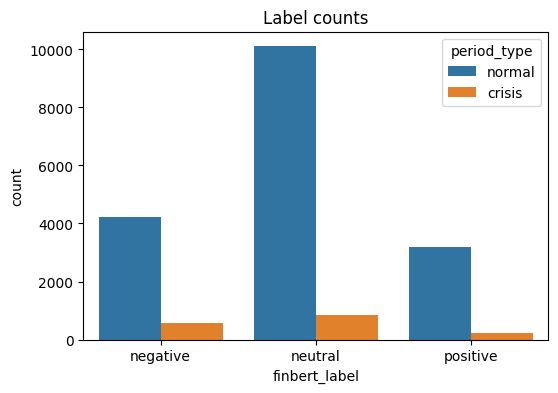

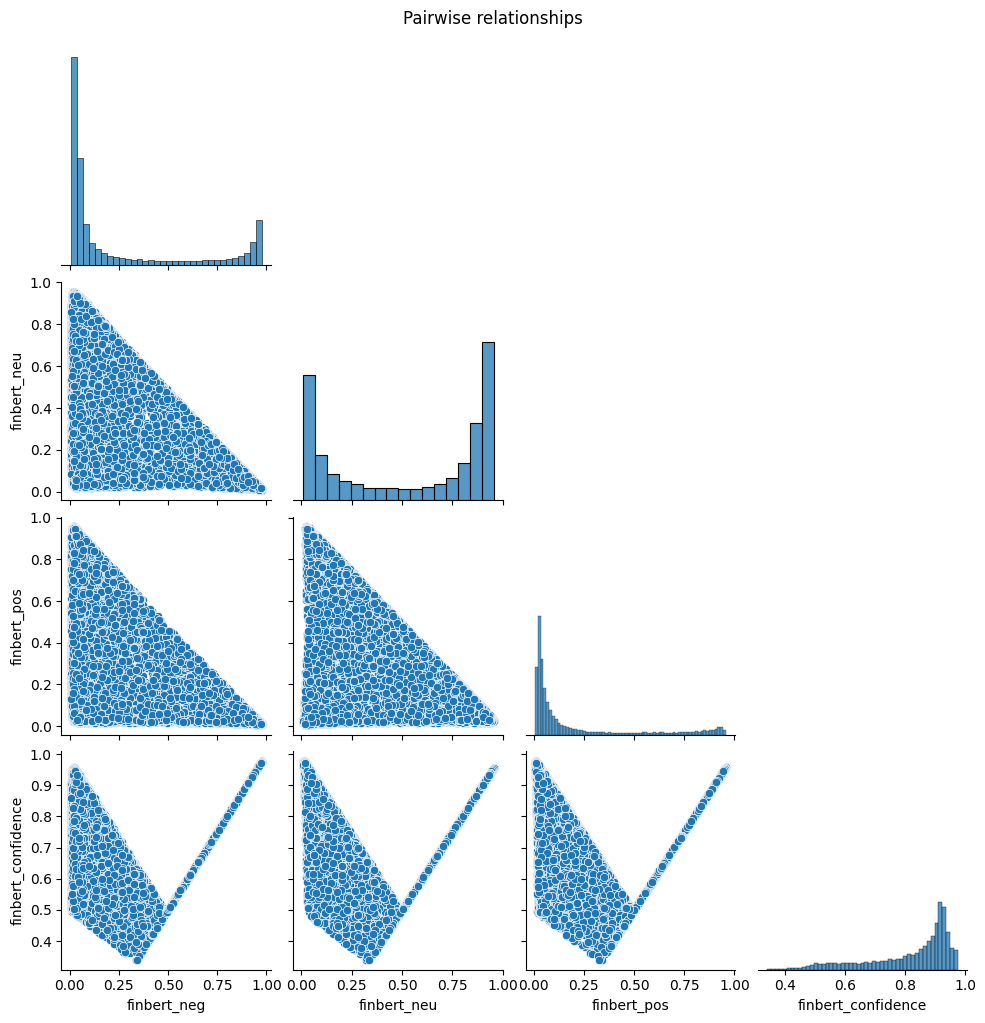

In [12]:
plot_sentiment_hist(df, save_path="../results/figures/sentiment_hist.png")
plot_confidence_hist(df, save_path="../results/figures/confidence_hist.png")
plot_label_counts(df, hue=None, save_path="../results/figures/label_counts.png")
plot_label_counts(df, hue="period_type", save_path="../results/figures/label_counts_by_period.png")
plot_pairwise(df, save_path="../results/figures/pairplot_scores.png")


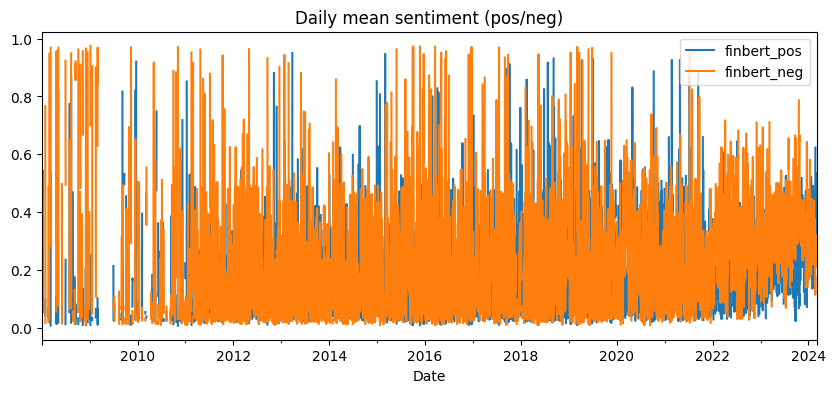

In [13]:
daily = (
    df.set_index("Date")
      .sort_index()
      .groupby(pd.Grouper(freq="D"))[["finbert_neg","finbert_neu","finbert_pos","finbert_confidence"]]
      .mean()
)
ax = daily[["finbert_pos","finbert_neg"]].plot(figsize=(10,4), title="Daily mean sentiment (pos/neg)")
ax.figure.savefig("../results/figures/daily_mean_sentiment.png", bbox_inches="tight", dpi=150)
